# RSI momentum trading strategy example

- This is a backtest example notebook
    - New style grid search

# Set up

Set up Trading Strategy data client.


In [8]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client

client = Client.create_jupyter_client()


# Render for Github web viewer
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)
# etup_charting_and_output(width=1500, height=1000)

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Load data

We use Binance data so we get a longer period of data.

In [9]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.utils.binance import create_binance_universe

target_time_bucket = TimeBucket.h8  # Upsample shifted data to this time bucket

strategy_universe = create_binance_universe(
    ["BTCUSDT", "ETHUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.h8,
    stop_loss_time_bucket=TimeBucket.h1,
    start_at=datetime.datetime(2019, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 2, 15),
    include_lending=False
)

print(f"We have loaded {strategy_universe.get_pair_count()} trading pairs")

# List of pair descriptions we used to look up pair metadata
our_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

  0%|          | 0/2 [00:00<?, ?it/s]

We have loaded 2 trading pairs


# Show loaded trading universe

Display generic troubleshooting information about the loaded data.

In [10]:
pairs = strategy_universe.data_universe.pairs  # Trading pairs metadata
candles = strategy_universe.data_universe.candles  # Candles for all trading pairs

print(f"Loaded {candles.get_candle_count():,} candles.")

for pair in pairs.iterate_pairs():
    pair_candles = candles.get_candles_by_pair(pair)
    first_close = pair_candles.iloc[0]["close"]
    first_close_at = pair_candles.index[0]
    print(f"Pair {pair} first close price {first_close} at {first_close_at}")


Loaded 11,228 candles.
Pair <Pair #1 BTC - USDT at exchange binance> first close price 3713.83 at 2019-01-01 00:00:00
Pair <Pair #2 ETH - USDT at exchange binance> first close price 133.56 at 2019-01-01 00:00:00


# Indicators

- Prepare indicators needed for the grid

In [11]:
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse


def calculate_eth_btc(strategy_universe: TradingStrategyUniverse):
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return series

def calculate_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int):
    weth_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WETH", "USDC"))
    wbtc_usdc = strategy_universe.get_pair_by_human_description((ChainId.ethereum, "test-dex", "WBTC", "USDC"))
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(wbtc_usdc.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(weth_usdc.internal_id)
    eth_btc = eth_price["close"] / btc_price["close"]
    return pandas_ta.rsi(eth_btc, length=length)

def create_indicators(parameters: StrategyParameters, indicators: IndicatorSet, strategy_universe: TradingStrategyUniverse, execution_context: ExecutionContext):
    # Calculate RSI for all pairs
    indicators.add("rsi", pandas_ta.rsi, {"length": parameters.rsi_length})  
    # Custom: ETC/BTC close price
    indicators.add("eth_btc", calculate_eth_btc, source=IndicatorSource.strategy_universe)
    # Custom: ETC/BTC RSI
    # indicators.add("eth_btc_rsi", calculate_eth_btc_rsi, parameters={"length": parameters.eth_btc_rsi_length}, source=IndicatorSource.strategy_universe)

# Trading algorithm

In [12]:
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradingstrategy.utils.groupeduniverse import resample_candles
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.weighting import weight_equal, weight_by_1_slash_n, weight_passthrouh
from tradeexecutor.strategy.alpha_model import AlphaModel
import numpy as np
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradingstrategy.chain import ChainId
from typing import List, Dict

import pandas as pd

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.state.visualisation import PlotKind, PlotShape, PlotLabel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.state.state import State



def decide_trades(
    input: StrategyInput,
) -> List[TradeExecution]:
    
    # Resolve our pair metadata for our two pair strategy
    parameters = input.parameters 
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    
    alpha_model = AlphaModel(input.timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])
    position_manager.log("decide_trades() start")

    # Resolve our pair metadata for our two pair strategy
    parameters = input.parameters 
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    
    alpha_model = AlphaModel(input.timestamp)
    btc_pair = position_manager.get_trading_pair(our_pairs[0])
    eth_pair = position_manager.get_trading_pair(our_pairs[1])
    position_manager.log("decide_trades() start")

    #
    # Indicators
    #
    # Calculate indicators for each pair.
    #

    # Per-trading pair calcualted data
    current_rsi_values = {}  # RSI yesterday
    previous_rsi_values = {}  # RSI day before yesterday
    current_price = {}  # Close price yesterday
    momentum = {btc_pair: 0, eth_pair: 0}
    eth_btc_rsi_yesterday = None

    for pair in [btc_pair, eth_pair]:        
        current_price[pair] = indicators.get_price(pair)
        current_rsi_values[pair] = indicators.get_indicator_value("rsi", pair=pair)
        previous_rsi_values[pair] = indicators.get_indicator_value("rsi", index=-2, pair=pair)

    eth_btc_yesterday = indicators.get_indicator_value("eth_btc")
    eth_btc_rsi_yesterday = indicators.get_indicator_value("eth_btc_rsi")
    if eth_btc_rsi_yesterday is not None:
        momentum[eth_pair] = (eth_btc_rsi_yesterday - 50) ** 3
        momentum[btc_pair] = (50 - momentum[eth_pair]) ** 3

    #
    # Trading logic
    #

    for pair in [btc_pair, eth_pair]:
        existing_position = position_manager.get_current_position_for_pair(pair)
        pair_open = existing_position is not None
        pair_momentum = momentum.get(pair, 0)
        signal_strength = max(pair_momentum, 0.1)  # Singal strength must be positive, as we do long-only
        if pd.isna(signal_strength):
            signal_strength = 0
        alpha_model.set_signal(pair, 0)

        if pair_open:
            # We have existing open position for this pair,
            # keep it open by default unless we get a trigger condition below
            position_manager.log(f"Pair {pair} already open")
            alpha_model.set_signal(pair, signal_strength, trailing_stop_loss=parameters.trailing_stop_loss)

        if current_rsi_values[pair] and previous_rsi_values[pair]:

            # Check for RSI crossing our threshold values in this cycle, compared to the previous cycle
            rsi_cross_above = current_rsi_values[pair] >= parameters.rsi_high and previous_rsi_values[pair] < parameters.rsi_high
            rsi_cross_below = current_rsi_values[pair] < parameters.rsi_low and previous_rsi_values[pair] > parameters.rsi_low

            if not pair_open:
                # Check for opening a position if no position is open
                if rsi_cross_above:
                    position_manager.log(f"Pair {pair} crossed above")
                    alpha_model.set_signal(pair, signal_strength, trailing_stop_loss=parameters.trailing_stop_loss)
            else:
                # We have open position, check for the close condition
                if rsi_cross_below:
                    position_manager.log(f"Pair {pair} crossed below")
                    alpha_model.set_signal(pair, 0)

    # Use alpha model and construct a portfolio of two assets
    alpha_model.select_top_signals(2)
    alpha_model.assign_weights(weight_passthrouh)
    alpha_model.normalise_weights()
    alpha_model.update_old_weights(state.portfolio)
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
    alpha_model.calculate_target_positions(position_manager, portfolio_target_value)
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=parameters.minimum_rebalance_trade_percent * portfolio.get_total_equity(),
    )

    #
    # Visualisations
    #

    if input.is_visualisation_enabled():

        visualisation = state.visualisation  # Helper class to visualise strategy output

        visualisation.plot_indicator(
            timestamp,
            f"ETH",
            PlotKind.technical_indicator_detached,
            current_price[eth_pair],
            colour="blue",
        )

        # Draw BTC + ETH RSI between its trigger zones for this pair of we got a valid value for RSI for this pair

        # BTC RSI daily
        if pd.notna(current_rsi_values[btc_pair]):
            visualisation.plot_indicator(
                timestamp,
                f"RSI",
                PlotKind.technical_indicator_detached,
                current_rsi_values[btc_pair],
                colour="orange",
            )

        # ETH RSI daily
        if pd.notna(current_rsi_values[eth_pair]):
            visualisation.plot_indicator(
                timestamp,
                f"RSI ETH",
                PlotKind.technical_indicator_overlay_on_detached,
                current_rsi_values[eth_pair],
                colour="blue",
                label=PlotLabel.hidden,
                detached_overlay_name=f"RSI",
            )

        # Low (vertical line)
        visualisation.plot_indicator(
            timestamp,
            f"RSI low trigger",
            PlotKind.technical_indicator_overlay_on_detached,
            parameters.rsi_low,
            detached_overlay_name=f"RSI",
            plot_shape=PlotShape.horizontal_vertical,
            colour="red",
            label=PlotLabel.hidden,
        )

        # High (vertical line)
        visualisation.plot_indicator(
            timestamp,
            f"RSI high trigger",
            PlotKind.technical_indicator_overlay_on_detached,
            parameters.rsi_high,
            detached_overlay_name=f"RSI",
            plot_shape=PlotShape.horizontal_vertical,
            colour="red",
            label=PlotLabel.hidden,
        )

        if eth_btc_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC",
                PlotKind.technical_indicator_detached,
                eth_btc_yesterday,
                colour="grey",
            )
        
        if eth_btc_rsi_yesterday is not None:
            visualisation.plot_indicator(
                timestamp,
                f"ETH/BTC RSI",
                PlotKind.technical_indicator_detached,
                eth_btc_rsi_yesterday,
                colour="grey",
            )

        state.visualisation.add_calculations(timestamp, alpha_model.to_dict())  # Record alpha model thinking

    return trades

# Search space

Prepare the parameters we search.

In [13]:
from pathlib import Path

import pandas_ta

from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.backtest.grid_search import GridCombination, prepare_grid_combinations
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse

# This is the path where we keep the result files around
storage_folder = Path("/tmp/v19-new-style-grid-search")


def calculate_eth_btc(strategy_universe: TradingStrategyUniverse):
    """ETH/BTC price series."""
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return series


def calculate_eth_btc_rsi(strategy_universe: TradingStrategyUniverse, length: int):
    """ETH/BTC RSI series."""
    eth = strategy_universe.get_pair_by_human_description(our_pairs[0])
    btc = strategy_universe.get_pair_by_human_description(our_pairs[1])    
    btc_price = strategy_universe.data_universe.candles.get_candles_by_pair(eth.internal_id)
    eth_price = strategy_universe.data_universe.candles.get_candles_by_pair(btc.internal_id)
    series = eth_price["close"] / btc_price["close"]  # Divide two series
    return pandas_ta.rsi(series, length=length)


def create_indicators(parameters: StrategyParameters, indicators: IndicatorSet, strategy_universe: TradingStrategyUniverse, execution_context: ExecutionContext):
    # Calculate RSI for all pairs
    indicators.add("rsi", pandas_ta.rsi, {"length": parameters.rsi_bars})  
    # Custom: ETC/BTC close price
    indicators.add("eth_btc", calculate_eth_btc, source=IndicatorSource.strategy_universe)
    # Custom: ETC/BTC RSI
    indicators.add("eth_btc_rsi", calculate_eth_btc_rsi, parameters={"length": parameters.eth_btc_rsi_bars}, source=IndicatorSource.strategy_universe)


class StrategyParameters:
    cycle_duration = CycleDuration.cycle_8h
    rsi_bars = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 21]  # The length of RSI indicator
    eth_btc_rsi_bars = 5  # The length of ETH/BTC RSI
    rsi_high = [55, 60, 67, 70, 73, 77, 82] # RSI trigger threshold for decision making
    rsi_low = [30, 40, 50, 60, 65, 70, 75]  # RSI trigger threshold for decision making
    allocation = 0.98 # Allocate 90% of cash to each position
    lookback_candles = 120
    minimum_rebalance_trade_percent = 0.05  # Don't do trades that would have less than 500 USD value change
    initial_cash = 10_000 # Start with 10k USD
    trailing_stop_loss = None

# Popular grid search combinations and indicators for them
combinations = prepare_grid_combinations(
    StrategyParameters, 
    storage_folder,
    create_indicators=create_indicators,
    strategy_universe=strategy_universe,
)

indicators = GridCombination.get_all_indicators(combinations)

print(f"We prepared {len(combinations)} grid search combinations with total {len(indicators)} indicators which need to be calculated")

We prepared 539 grid search combinations with total 24 indicators which need to be calculated


# Grid search

Run a grid search on the above function.

In [14]:
from tradeexecutor.backtest.grid_search import perform_grid_search

grid_search_results = perform_grid_search(
    decide_trades,
    strategy_universe,
    combinations,
    max_workers=8,
    trading_strategy_engine_version="0.5",
    multiprocess=True,
)

Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_8h_BTC-USDT-ETH-USDT_2019-01-01-2024-02-15
No cached grid search results found from previous runs


Grid searching using 8 processes: rsi_bars, rsi_high, rsi_low:   0%|          | 0/539 [00:00<?, ?it/s]

# Grid search result table

- Show individual profit and risk for each grid combination

In [15]:
# Set Jupyter Notebook output mode parameters
from tradeexecutor.analysis.grid_search import analyse_grid_search_result
from tradeexecutor.analysis.grid_search import visualise_table

# Print extension of our backtest
print(f"Grid search combinations available: {len(grid_search_results)}")

table = analyse_grid_search_result(grid_search_results)
visualise_table(table)


Grid search combinations available: 539


# Heatmap

- Verify that results look to cluster around certain values and do not follow a random pattern]

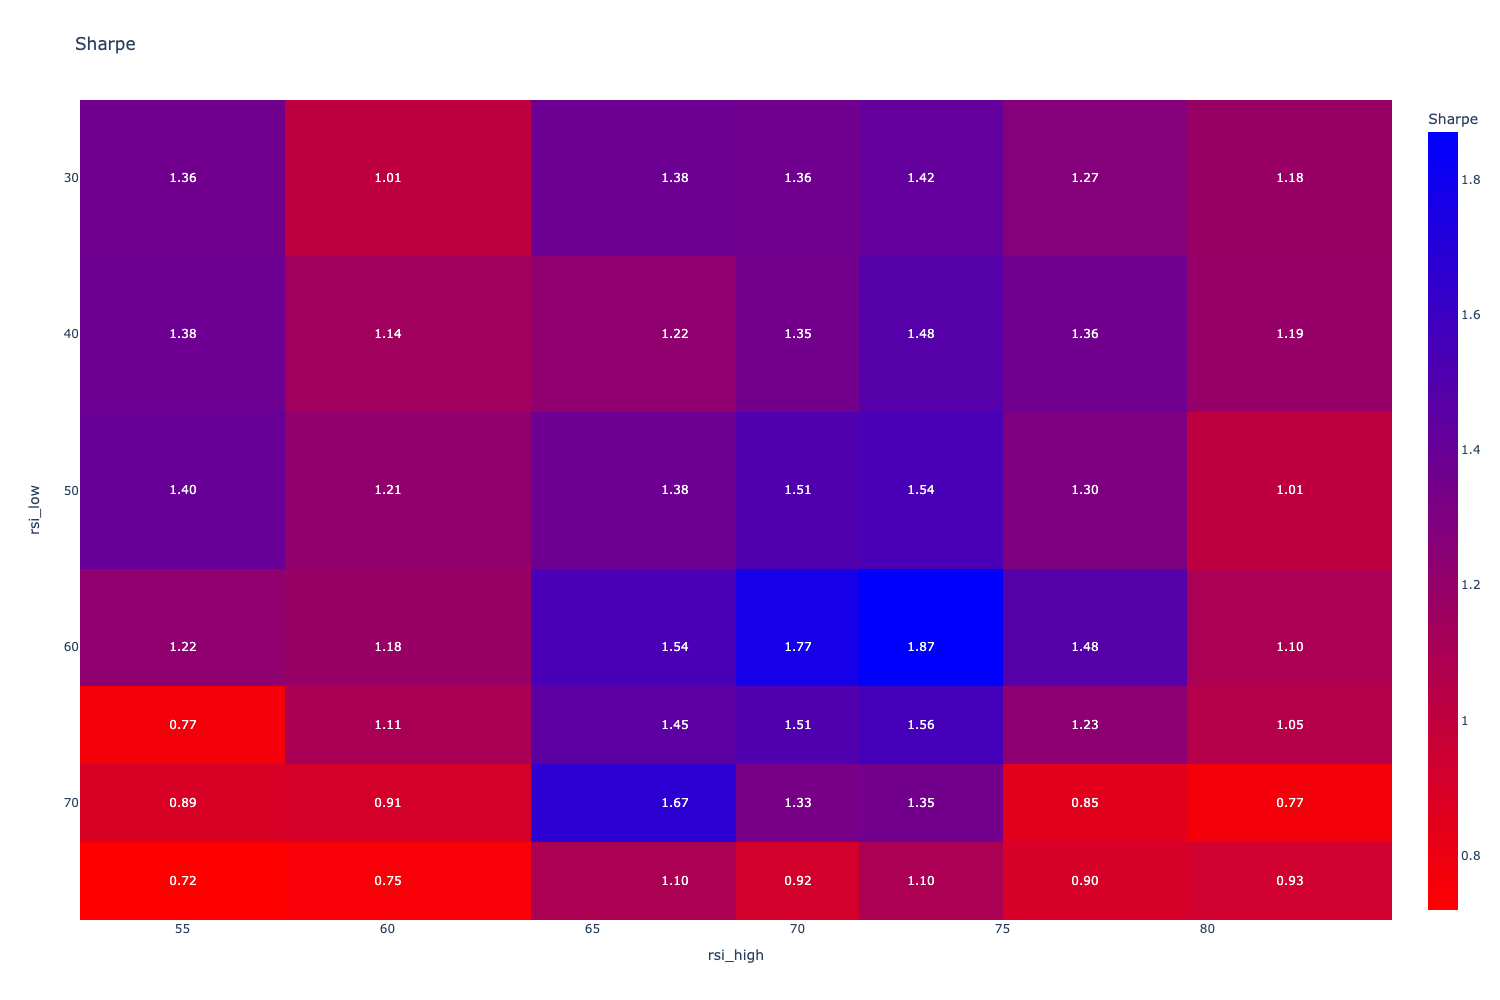

In [16]:
from tradeexecutor.analysis.grid_search import visualise_heatmap_2d


# RSI length = 8
heatmap_data = table.xs((8,), level=("rsi_bars",))

fig = visualise_heatmap_2d(heatmap_data, "rsi_low", "rsi_high", "Sharpe")
display(fig)

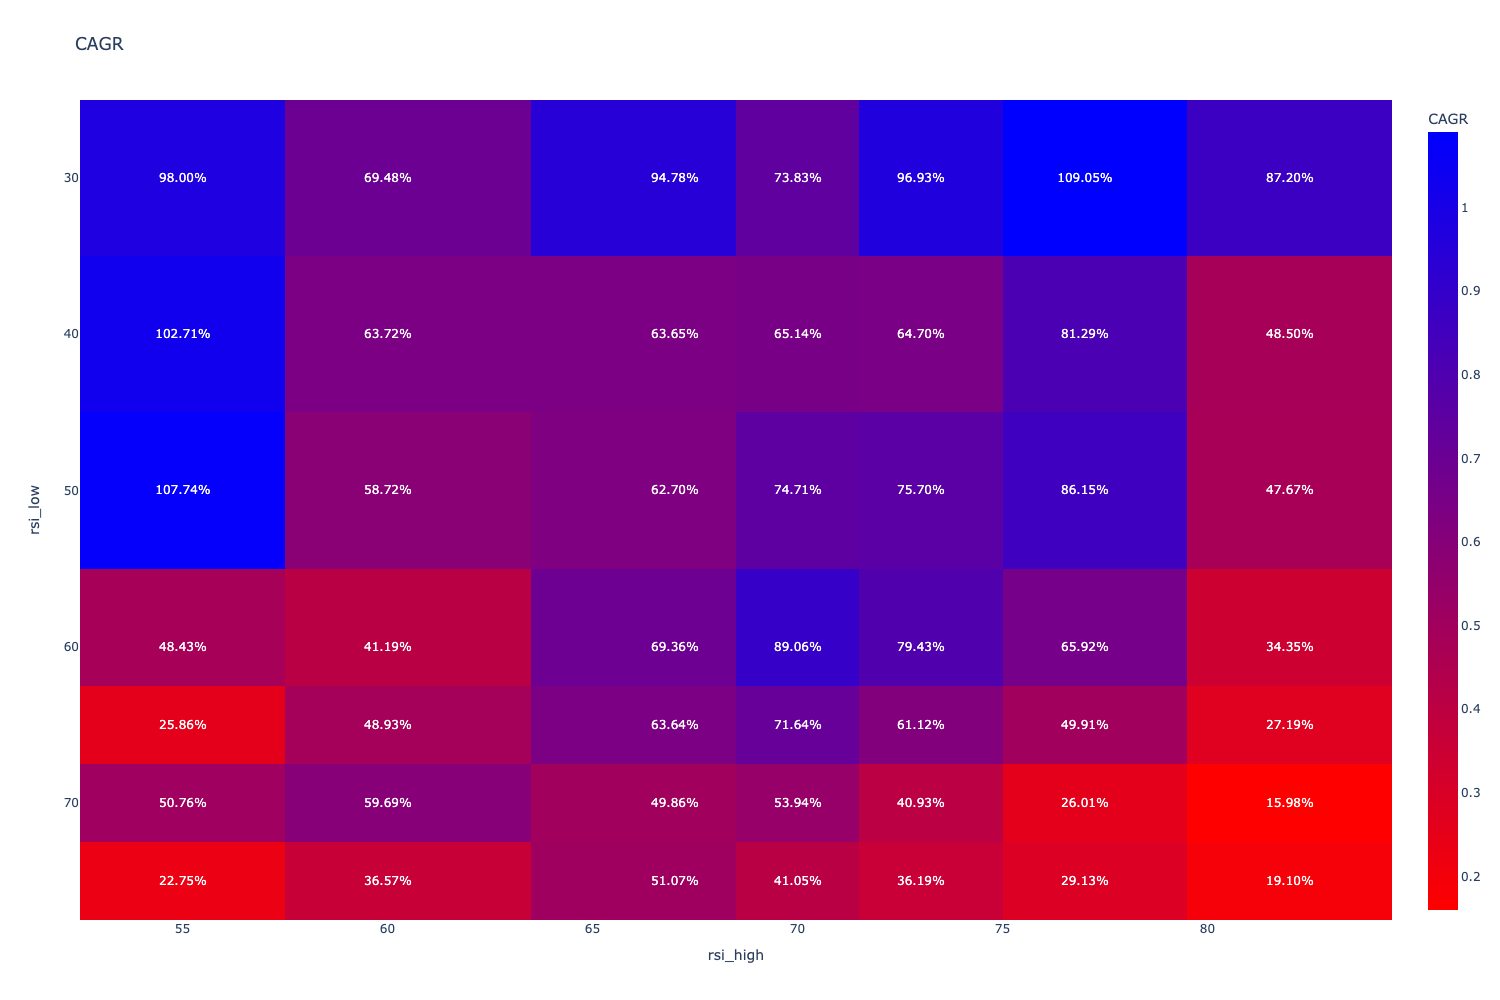

In [17]:
from tradeexecutor.analysis.grid_search import visualise_heatmap_2d


# RSI length = 9
heatmap_data = table.xs((9,), level=("rsi_bars",))

fig = visualise_heatmap_2d(heatmap_data, "rsi_low", "rsi_high", "CAGR")
display(fig)


# Equity curve comparison

- Compare the equity curves of all grid search results
- Show the grid search parameters as the tool tip
- Add buy and hold benchmarks on the plot

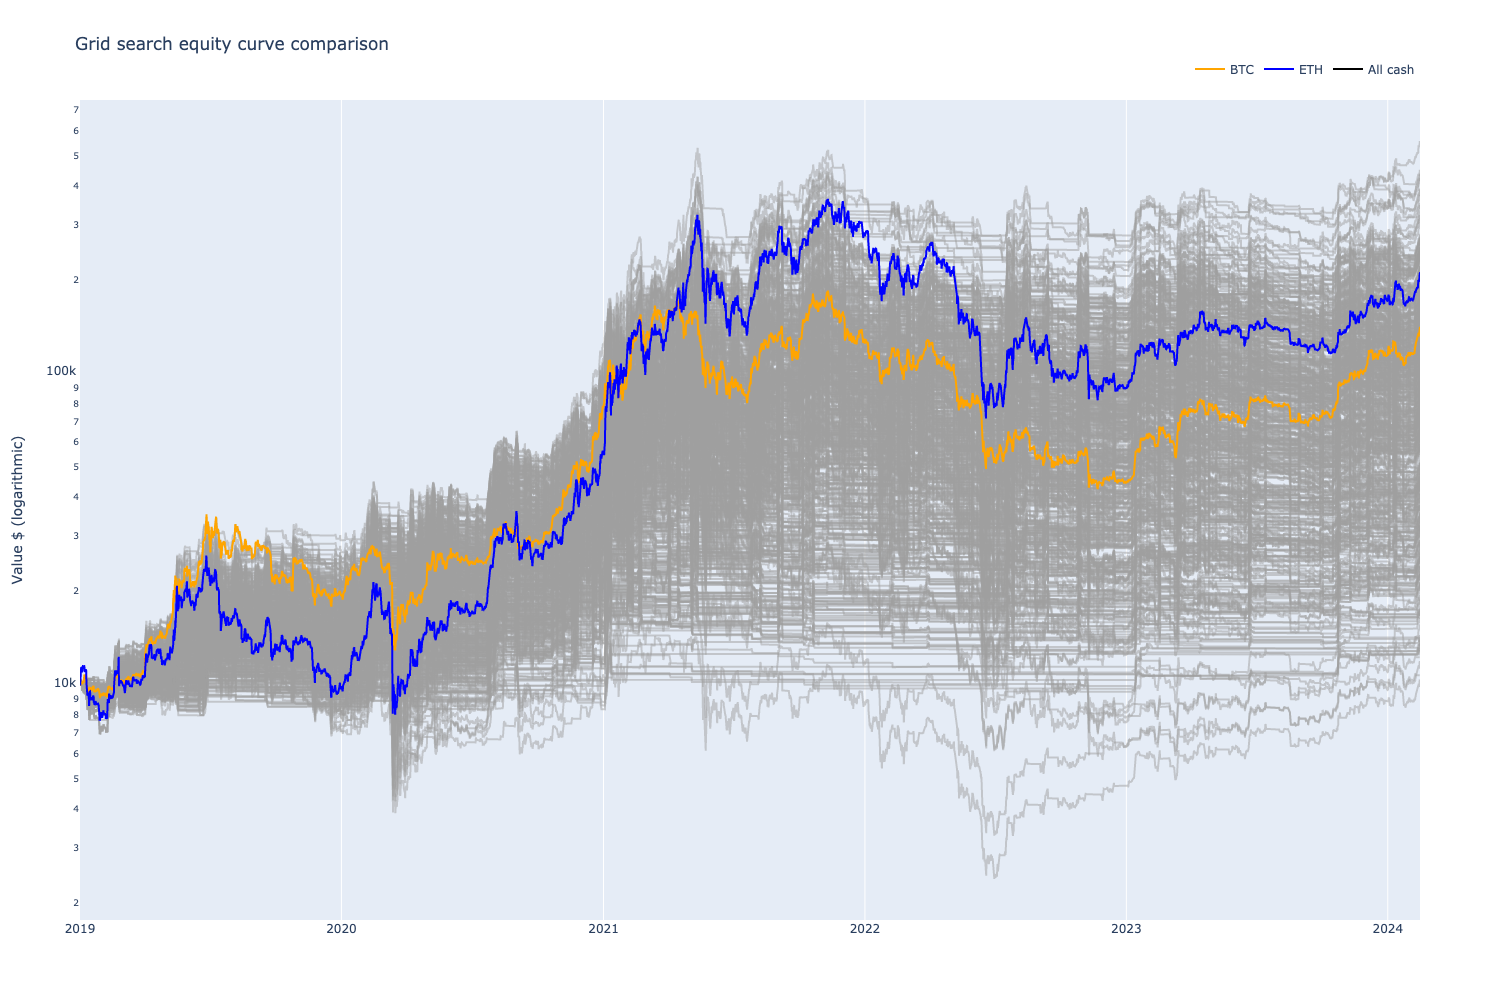

In [18]:
from tradeexecutor.analysis.grid_search import visualise_grid_search_equity_curves
from tradeexecutor.visual.benchmark import create_benchmark_equity_curves

benchmark_indexes = create_benchmark_equity_curves(
    strategy_universe,
    {"BTC": our_pairs[0], "ETH": our_pairs[1]},
    initial_cash=StrategyParameters.initial_cash,
)

fig = visualise_grid_search_equity_curves(
    grid_search_results,
    benchmark_indexes=benchmark_indexes,
    log_y=True,
)
fig.show()